# ASR Assignment 2022-23

This notebook has been provided as a template to get you started on the assignment.  Feel free to use it for your development, or do your development directly in Python.

You can find a full description of the assignment [here](http://www.inf.ed.ac.uk/teaching/courses/asr/2022-23/coursework.pdf).

You are provided with two Python modules `observation_model.py` and `wer.py`.  The first was described in [Lab 3](https://github.com/ZhaoZeyu1995/asr_labs/blob/master/asr_lab3_4.ipynb).  The second can be used to compute the number of substitution, deletion and insertion errors between ASR output and a reference text.

It can be used as follows:

```python
import wer

my_refence = 'A B C'
my_output = 'A C C D'

wer.compute_alignment_errors(my_reference, my_output)
```

This produces a tuple $(s,d,i)$ giving counts of substitution,
deletion and insertion errors respectively - in this example (1, 0, 1).  The function accepts either two strings, as in the example above, or two lists.  Matching is case sensitive.

## Template code

Assuming that you have already made a function to generate an WFST, `create_wfst()` and a decoder class, `MyViterbiDecoder`, you can perform recognition on all the audio files as follows:


In [1]:
import glob
import os
import wer
import observation_model
import openfst_python as fst
import math

In [2]:
weight_type = 'log'
# weight_type = 'tropical'

In [3]:
from subprocess import check_call
from IPython.display import Image
def draw_f(f):
    f.draw('tmp.dot', portrait=True)
    check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
    return Image(filename='tmp.png')

In [4]:
def add_to_file(file: str, txt: str):
    f = open(file, 'a')
    f.write(txt)
    f.close()

In [5]:
def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex

lex = parse_lexicon('lexicon.txt')

In [6]:
def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
    
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # your code here
    # .add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    for word in lexicon:
        word_table.add_symbol(word)
        
    phone_table.add_symbol('<eps>')
    for word in list(lexicon):
        for phone in lexicon[word]:
            phone_table.add_symbol(phone)
    
    state_table.add_symbol('<eps>')
    for word in list(lexicon):
        for phone in lexicon[word]:
            for i in range(n):
                state_table.add_symbol(f"{phone}_{i+1}")
    

    return word_table, phone_table, state_table

word_table, phone_table, state_table = generate_symbol_tables(lex)

In [7]:
def generate_phone_wfst(f, start_state, phone, n, word = '', isLast=False):
    """
    Generate a WFST representing an n-state left-to-right phone HMM.
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        phone (str): the phone label 
        n (int): number of emitting states of the HMM
        
    Returns:
        the final state of the FST
    """
    
    current_state = start_state
    eps = phone_table.find('<eps>')
    out = word_table.find(word)
    
    for i in range(1, n+1):
    
        in_label = state_table.find('{}_{}'.format(phone, i))
        
        next_state = f.add_state()
        f.add_arc(current_state, fst.Arc(in_label, eps, fst.Weight(weight_type, -math.log(0.1)), current_state))
        if (isLast and i >= n):
            f.add_arc(current_state, fst.Arc(in_label, out, fst.Weight(weight_type, -math.log(0.9)), next_state))
        else:
            f.add_arc(current_state, fst.Arc(in_label, eps, fst.Weight(weight_type, -math.log(0.9)), next_state))
        
        current_state = next_state
    
    return current_state

In [8]:
def generate_word_wfst(f, start_state, word, n):
    """ Generate a WFST for any word in the lexicon, composed of n-state phone WFSTs.
        This will currently output phone labels.  
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        word (str): the word to generate
        n (int): states per phone HMM
        
    Returns:
        the constructed WFST
    
    """

    current_state = start_state
    phone_list = lex[word]
    for phone in phone_list[:-1]:
        current_state = generate_phone_wfst(f, current_state, phone, n)
    current_state = generate_phone_wfst(f, current_state, phone_list[-1], n, word, True)
    f.set_final(current_state)
    
    return current_state

In [9]:
def generate_word_sequence_recognition_wfst(n = 3):
    """ generate a HMM to recognise any sequence of words in the lexicon
    
    Args:
        n (int): states per phone HMM

    Returns:
        the constructed WFST
    
    """
    
    f = fst.Fst(weight_type)
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    
    N = len(lex.keys())
    
    for word in lex.keys():
        new_start_state = f.add_state()
        f.add_arc(start_state, fst.Arc(state_table.find("<eps>"), phone_table.find("<eps>"), fst.Weight(weight_type, -math.log(1/N)), new_start_state))
        last_state = generate_word_wfst(f, new_start_state, word, n)
        f.set_final(last_state)
        f.add_arc(last_state, fst.Arc(state_table.find("<eps>"), phone_table.find("<eps>"), fst.Weight(weight_type, -math.log(1)), start_state))
    
    return f

In [10]:
lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)  # we won't use state_table in this lab

def generate_L_wfst(lex):
    """ Express the lexicon in WFST form
    
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
    
    Returns:
        the constructed lexicon WFST
    
    """
    L = fst.Fst()
    
    # create a single start state
    start_state = L.add_state()
    L.set_start(start_state)
    
    for (word, pron) in lex.items():
        
        current_state = start_state
        for (i,phone) in enumerate(pron):
            next_state = L.add_state()
            
            if i == len(pron)-1:
                # add word output symbol on the final arc
                L.add_arc(current_state, fst.Arc(phone_table.find(phone), \
                                                 word_table.find(word), None, next_state))
            else:
                L.add_arc(current_state, fst.Arc(phone_table.find(phone),0, None, next_state))
            
            current_state = next_state
                          
        L.set_final(current_state)
        L.add_arc(current_state, fst.Arc(0, 0, None, start_state))
        
    L.set_input_symbols(phone_table)
    L.set_output_symbols(word_table)                      
    
    return L

In [11]:
def create_wfst(n = 3):
    f = generate_word_sequence_recognition_wfst(n)
    f.set_input_symbols(state_table)
    f.set_output_symbols(word_table)
    
    return f

In [12]:
class MyViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is not really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()
    
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []
        self.B = [] # B[t][i]
        self.W = []
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append(['']*self.f.num_states())
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        start_state = self.f.start()
        N = len(lex)
        for arc in self.f.arcs(start_state):
            s = arc.nextstate
            self.V[0][s] = -math.log(1/N)

        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
#         states_to_traverse = list(range(self.f.num_states())) # traverse all states
#         while states_to_traverse:
            
#             # Set i to the ID of the current state, the first 
#             # item in the list (and remove it from the list)
#             i = states_to_traverse.pop(0)   
        
#             # don't bother traversing states which have zero probability
#             if self.V[t][i] == self.NLL_ZERO:
#                     continue
        
#             for arc in self.f.arcs(i):
                
#                 if arc.ilabel == 0:     # if <eps> transition
                  
#                     j = arc.nextstate   # ID of next state  
                
#                     if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
#                         # this means we've found a lower-cost path to
#                         # state j at time t.  We might need to add it
#                         # back to the processing queue.
#                         self.V[t][j] = self.V[t][i] + float(arc.weight)
                  
#                         if j not in states_to_traverse:
#                             states_to_traverse.append(j)

        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
        for i in self.f.states():
            
            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
#                         print(tp, ep, self.V[t-1][i])
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            olbl = arc.olabel
                            olbl = self.f.output_symbols().find(olbl)
                            self.W[t][j] = olbl
    
    def finalise_decoding(self):
        
        # TODO - exercise
        states = list(range(self.f.num_states()))
        for i in states:
            prob_final = float(self.f.final(i)) # probablity of being the end state (0 for non finals, and upwards of 1 if one final state, or split between all final states)
            if (self.V[-1][i] < self.NLL_ZERO):
                if (prob_final == math.inf): # not a final state
                    self.V[-1][i] = self.NLL_ZERO
                else: # is a final state
                    self.V[-1][i] += prob_final # includes the weighting of ending at each of the final states in the path towards them in the last step
        
    def decode(self):
        
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.traverse_epsilon_arcs(t)
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        
        self.finalise_decoding()
    
    def backtrace(self):
        
        # TODO - exercise 
        
        # complete code to trace back through the
        # best state sequence
        
        # You'll need to create a structure B_j(t) to store the 
        # back-pointers (see lectures), and amend the functions above to fill it.
        
#         for w in self.W:
#             print(dict(enumerate(w)))

        # --------------

#         T = self.om.observation_length()
#         current = -1
#         for i in range(self.f.num_states()):
#             if (float(self.f.final(i)) != math.inf):
#                 if (self.B[T][i] != -1):
#                     current = i
#                     break
#         if (current == -1):
#             raise Exception('No valid path')
#         seq = [current]
#         currentStr = ''
#         strSeq = ''
        
#         for t in range(T,-1, -1):
#             tmpStr = self.W[t][current]
#             if not(tmpStr in ['', '<eps>',  currentStr]):
#                 currentStr = tmpStr
#                 strSeq = f'{currentStr} {strSeq}'
        
       
#             current = self.B[t][current]
#             seq.insert(0, current)
        
        
#         strSeq = strSeq.strip()
#         best_state_sequence = (seq, strSeq)
        
#         return best_state_sequence


        # --------------------------------------------------
        T = self.om.observation_length()
        current = -1
        for i in range(self.f.num_states()):
            if (float(self.f.final(i)) != math.inf): # if i is final
                if (self.B[T][i] != -1):
                    if (current == -1):
                        current = i
                    elif (self.V[-1][current] > self.V[-1][i]):
                        current = i
        if (current == -1):
            raise Exception('No valid path')
        seq = [current]
        currentStr = ''
        strSeq = ''
        
        for t in range(T,-1, -1):
            tmpStr = self.W[t][current]
            if not(tmpStr in ['', '<eps>']):
#             if True:
                currentStr = tmpStr
                strSeq = f'{currentStr} {strSeq}'
        
       
            current = self.B[t][current]
            seq.insert(0, current)
        
        
        strSeq = strSeq.strip()
        best_state_sequence = (seq, strSeq)
        
        return best_state_sequence
    
    # --------------------------------------------------

#         best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
#         best_state_sequence = [best_final_state]
#         best_out_sequence = []

#         t = self.om.observation_length()   # ie T
#         j = best_final_state

#         while t >= 0:
#             i = self.B[t][j]
#             best_state_sequence.append(i)
#             best_out_sequence = [self.W[t][j]] + best_out_sequence  # computer scientists might like
#                                                                                 # to make this more efficient!

#             # continue the backtrace at state i, time t-1
#             j = i  
#             t-=1

#         best_state_sequence.reverse()

#         # convert the best output sequence from FST integer labels into strings
# #         print(best_state_sequence)
# #         print([label for label in best_out_sequence])
# #         print([self.f.output_symbols().find(label) for label in best_out_sequence])
#         best_out_sequence = ' '.join([ label for label in best_out_sequence if not(label in ['', '<eps>'])])
# #         best_out_sequence = ' '.join([ self.f.output_symbols().find(label) for label in best_out_sequence if not(label in ['', '<eps>'])])

#         return (best_state_sequence, best_out_sequence)


In [19]:
def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription

def run():
    f = create_wfst()
    
    files = list(glob.glob('/group/teaching/asr/labs/recordings/*.wav'))
    
    # clear results file
    file = open('results.txt', 'w')
    file.write('')
    file.close()
    
#     for i in range(len(files)):
#         wav_file = files[i]
#         transcription = read_transcription(wav_file)
#         print(f'{i}: {transcription}')
#     return

    # 10:15
    # 37:42
#     for wav_file in files[10:15]:    # replace path if using your own audio files
    for wav_file in files:    # replace path if using your own audio files
        decoder = MyViterbiDecoder(f, wav_file)
        
        decoder.decode()
#         print(decoder.V)
#         input()
        (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
                                                   # to return the words along the best path


        transcription = read_transcription(wav_file)
        text = (f"\n\n{state_path}\n\n[{words}]\n[{transcription}]")
        error_counts = wer.compute_alignment_errors(transcription, words)
        word_count = len(transcription.split())

        res = f'{error_counts} {word_count}\n'     # you'll need to accumulate these to produce an overall Word Error Rate
        print(f'{words}\n{transcription}\n{res}\n')
#         add_to_file('results.txt', f'{text}\n{res}')
        add_to_file('wer_data.txt', res)

In [20]:
run()

pickled the picked the picked peter piper the peck a the peck of pickled peppers picked where's the peck of pickled peppers peter piper picked picked the picked
peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
(1, 0, 11) 17


pickled the picked picked the the peter picked the of peck of pickled peppers picked the
peter picked a peck of pickled peppers
(1, 0, 9) 7


pickled the the the the peck of pickled peppers picked picked the
a peck of pickled peppers picked
(1, 0, 6) 6


pickled the picked the peter piper peter piper picked picked the the
peter piper peter piper
(0, 0, 8) 4


pickled picked picked where's the pickled pickled peppers picked picked the
where's the peck of pickled peppers picked
(1, 1, 5) 7


peck peter piper peck pickled peppers picked the the the
peter piper pickled peppers
(0, 0, 6) 4


where's peter picked picked picked the
where's peter
(0, 0, 4) 2


picked the piper peck picked peppers of peter a picked the the

picked the picked the picked the of piper picked the a where's where's of peck picked pickled where's picked the the
peter piper picked where's the peck of
(3, 0, 14) 7


picked the pickled of of where's pickled peppers picked of piper a picked picked the of a picked of pickled peppers picked picked picked
pickled peppers pickled peppers peter piper picked a peck of pickled peppers
(3, 0, 12) 12


picked the where's the the of a of of pickled picked where's peter of piper a picked picked the
the peck of pickled peppers peter piper picked
(2, 0, 11) 8


picked the the the of piper picked the of of picked picked of pickled peppers picked the
peter piper picked a peck of pickled peppers
(3, 0, 9) 8


picked the picked of the peter of the peter where's pickled peppers piper pickled of piper picked picked the the
pickled peter peppers pickled peppers piper of piper
(2, 0, 12) 8


where's the pickled where's peck picked peppers picked the picked picked
pickled where's peck peck peppers
(1, 0

picked the picked picked picked pickled piper of picked picked picked where's picked picked where's picked picked the the
piper peck pickled peppers
(3, 0, 15) 4


picked the a picked pickled picked the of picked picked the
peck pickled peter
(2, 0, 8) 3


picked picked the pickled where's the picked picked picked the picked
peter where's the peck
(2, 0, 7) 4


picked the picked where's peck pickled picked the the
the peppers peck pickled
(1, 0, 5) 4


picked a a a picked piper pickled the picked pickled peck a where's picked the picked
peter of a peck of peppers
(4, 0, 10) 6


picked picked the peter peter pickled of peter of peter of peck the
peter peter peter peter peter
(1, 0, 8) 5


picked the picked piper picked peter picked peck the
piper picked peter
(0, 0, 6) 3


picked the piper of peck where's peter of peter the
piper peppers peter picked
(2, 0, 6) 4


the peck of picked pickled picked peppers picked the the
a peck of pickled peppers
(1, 0, 5) 5


picked the piper pickled pi

picked the picked peck of pickled peppers picked the peter peter peter the
the peck of pickled peppers peter piper picked
(2, 0, 5) 8


picked the peter of pickled pickled peppers the the the picked
peter picked pickled peppers
(1, 0, 7) 4


picked the where's the peck of pickled peppers picked the picked
where's the peck of pickled peppers
(0, 0, 5) 6


picked the of peck of pickled peppers the the the the
a peck of pickled peppers
(1, 0, 6) 5


picked the the the a picked the the of peck the picked peter a picked picked the the the
piper picked a peck of peter
(1, 1, 14) 6


picked the the the peter picked pickled picked peck of the the of where's picked the the
peter pickled a peck of peppers
(2, 0, 11) 6


picked the picked piper a pickled peter picked peck
piper pickled peter
(0, 0, 6) 3


picked the where's peter of piper a pickled peppers peck
where's peter piper pickled peppers
(0, 0, 5) 5


picked the piper peter a picked a where's a a peter picked picked the peck
piper peter 

picked picked the where's the of piper of picked picked peter peter of piper of picked picked the
where's the peck of pickled peppers peter piper picked
(3, 0, 9) 9


picked the the picked peck of piper pickled peter pickled pickled of peck peter peck picked piper where's of where's peter pickled peppers picked picked the the
peck a piper pickled peter of of the peck peter picked piper where's peppers pickled peppers picked
(3, 1, 11) 17


picked the peppers of piper pickled the peter picked the picked the
peppers of piper pickled the peter
(0, 0, 6) 6


picked the piper picked peter pickled where's the peppers picked the picked
piper picked peter pickled where's the peppers
(0, 0, 5) 7


picked the peck of piper peter picked picked the the
the peck of piper peter picked
(0, 0, 4) 6


picked the peck piper peter peter piper picked the peppers picked the the
piper peter peter piper picked the peppers
(0, 0, 6) 7


picked the where's of peppers of peck peter picked picked the the picked 

picked the the peck picked a peck where's piper of the the of a picked the the
peck of picked peppers piper peter picked
(4, 0, 10) 7


picked the picked the peter piper picked peppers picked the
peter piper picked peppers
(0, 0, 6) 4


picked the picked pickled peppers a picked picked the
pickled peppers picked
(0, 0, 6) 3


picked the peter picked piper picked of peck of peck picked peppers picked the the the
peter piper picked a peck of peppers
(1, 0, 9) 7


picked the piper picked a picked pickled peck peppers picked the the the
piper picked pickled peppers
(0, 0, 9) 4


picked the peter of piper pickled peppers picked the the picked
peter piper pickled peppers
(0, 0, 7) 4


peck the peck picked of where's a picked picked the the
peck the peppers peck
(0, 1, 8) 4


picked the where's the piper of pickled where's picked the
piper the piper pickled peppers
(2, 0, 5) 5


picked the picked of picked piper of pickled the picked the a where's picked the picked the the
peter picked piper 

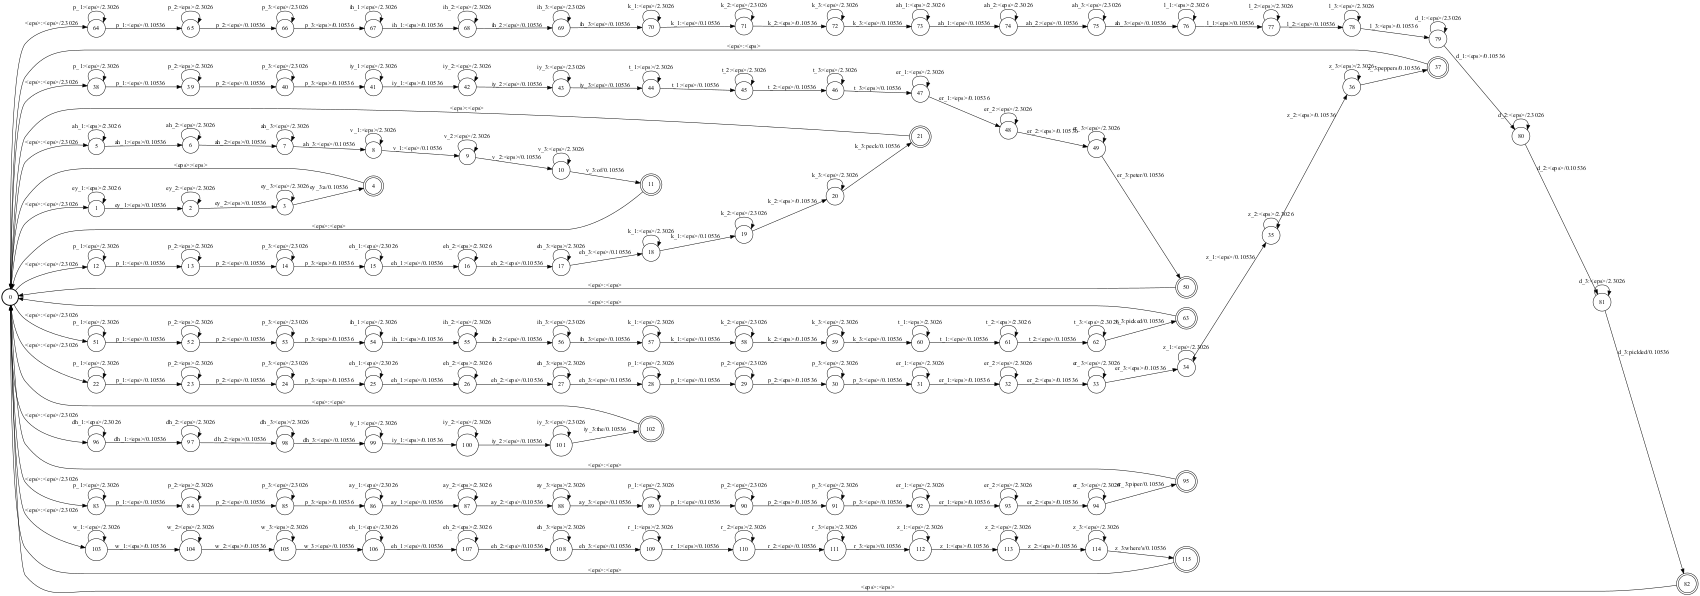

In [15]:
f = create_wfst()
draw_f(f)

In [25]:
file = open('wer_data.txt', 'r')
wer_counts = file.read()
file.close()

S, D, I, N = 0, 0, 0, 0
wer_counts = wer_counts.split("\n")
IndexCount = len(wer_counts)
for wer_elem in wer_counts:
    wer_elem = wer_elem.replace("(", "").replace(")", "").replace(",", "").split(" ")
    S += int(wer_elem[0])
    D += int(wer_elem[1])
    I += int(wer_elem[2])
    N += int(wer_elem[3])

WER = (S + D + I) / N
print(IndexCount, WER, S, D, I, N)

328 1.454054054054054 604 19 2874 2405


In [ ]:
add_to_file('test.txt', 'test1')